In [1]:
import tensorflow
print(tensorflow.__version__)

2.13.0


<h1>Our model so far:</h1>


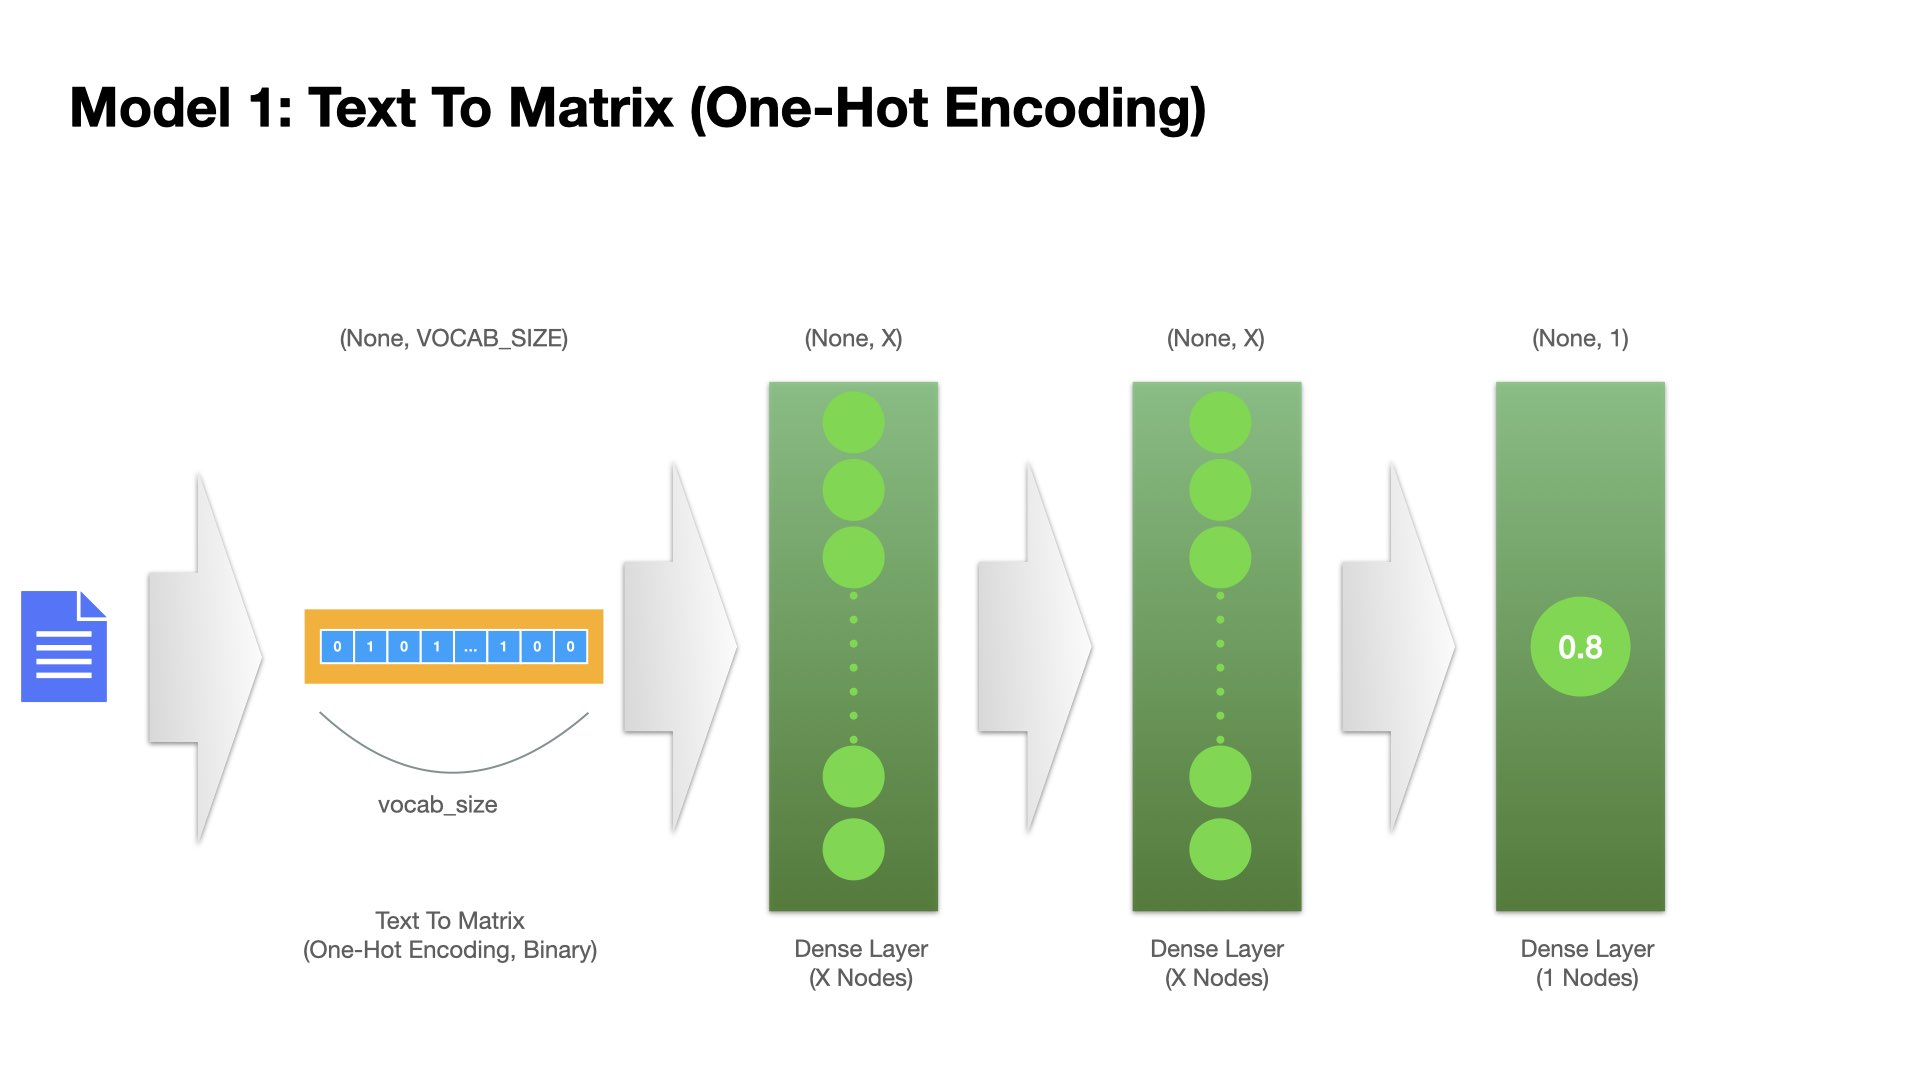

# Dataset
https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [4]:
filepath_dict = {'yelp':   'dataP05/yelp_labelled.txt',
                 'amazon': 'dataP05/amazon_cells_labelled.txt',
                 'imdb':   'dataP05/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


# Baseline model

In [5]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    predictions_log = classifier.predict(X_test)
    print("----------", source, "-----------")
    print('Accuracy score: ', format(accuracy_score(y_test, predictions_log)))
    print('Precision score: ', format(precision_score(y_test, predictions_log)))
    print('Recall score: ', format(recall_score(y_test, predictions_log)))
    print('F1 score: ', format(f1_score(y_test, predictions_log)))

---------- yelp -----------
Accuracy score:  0.796
Precision score:  0.8319327731092437
Recall score:  0.7615384615384615
F1 score:  0.7951807228915662
---------- amazon -----------
Accuracy score:  0.796
Precision score:  0.8099173553719008
Recall score:  0.7777777777777778
F1 score:  0.7935222672064778
---------- imdb -----------
Accuracy score:  0.7486631016042781
Precision score:  0.7156862745098039
Recall score:  0.8021978021978022
F1 score:  0.756476683937824


# Keras Text Vectorization

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

1. standardize each sample (usually lowercasing + punctuation stripping) .
2. split each sample into substrings (usually words) .
3. recombine substrings into tokens (usually ngrams).
4. index tokens (associate a unique int value with each token) .
5.transform each sample using this index, either into a vector of ints or a dense float vector.¹

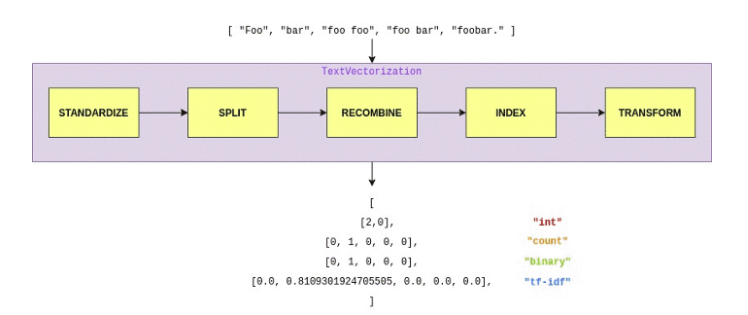

https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/

In [8]:
#standardize='lower_and_strip_punctuation',
#split='split_on_whitespace',
vectorize_layer = TextVectorization(
    max_tokens=None, vocabulary=None,
    output_mode='binary', output_sequence_length=None
)
# output_sequence_length only valid for int output mode to create a tensor of size [batch_size, output_sequence_length]
# pad_to_max_tokens  only valid in binary, count, and tf-idf modes. The output will have its feature axis padded to max_tokens even if the number of unique tokens in the vocabulary is less than max_tokens.


In [9]:
df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)


# Once we have our handles, we format the datasets in a Keras-fit compatible
# format: a tuple of the form (text_data, label).
train_dataset = tf.data.Dataset.from_tensor_slices((sentences_train,y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((sentences_test,y_test))

# We also create a dataset with only the textual data in it. This will be used
# to build our vocabulary later on.
text_dataset = tf.data.Dataset.from_tensor_slices((sentences_train))



In [10]:
# Now that the vocab layer has been created, call `adapt` on the text-only
# dataset to create the vocabulary
vectorize_layer.adapt(text_dataset.batch(64))

In [14]:
vectorize_layer.get_vocabulary()

['[UNK]',
 'the',
 'and',
 'was',
 'i',
 'to',
 'a',
 'is',
 'it',
 'this',
 'of',
 'food',
 'not',
 'for',
 'in',
 'place',
 'good',
 'we',
 'very',
 'service',
 'be',
 'with',
 'my',
 'great',
 'were',
 'that',
 'so',
 'had',
 'but',
 'you',
 'have',
 'are',
 'back',
 'they',
 'on',
 'here',
 'like',
 'at',
 'our',
 'time',
 'go',
 'just',
 'as',
 'all',
 'an',
 'really',
 'will',
 'best',
 'there',
 'restaurant',
 'one',
 'your',
 'only',
 'if',
 'also',
 'their',
 'nice',
 'never',
 'up',
 'out',
 'no',
 'dont',
 'would',
 'what',
 'friendly',
 'ever',
 'amazing',
 'which',
 'us',
 'he',
 'did',
 'by',
 'been',
 'wont',
 'when',
 'well',
 'staff',
 'or',
 'minutes',
 'im',
 'from',
 'delicious',
 'again',
 'vegas',
 'much',
 'love',
 'came',
 'pizza',
 'me',
 'has',
 'experience',
 'even',
 'eat',
 'bad',
 'about',
 'stars',
 'menu',
 'its',
 'get',
 'definitely',
 'always',
 'want',
 'wait',
 'than',
 'steak',
 'some',
 'other',
 'made',
 'got',
 'disappointed',
 'better',
 'wasnt

In [16]:
len(vectorize_layer.get_vocabulary())

1750

## Keras (Functional API)

In [27]:
##LAYERS

# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one doc
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')

# The first layer in our model is the vectorization layer. After this layer,
# we have a tensor of shape (batch_size, max_len) containing vocab indices.

x = vectorize_layer(text_input)
x = layers.Dense(10, activation='relu')(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
model = tf.keras.Model(text_input, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
# https://keras.io/api/losses/
# https://keras.io/api/optimizers/
# Ojo con las metricas ya que el entrenamiento es en batches
# https://keras.io/api/models/model_training_apis/
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
batch_size = 32
epochs = 20

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss")
]

# Fit the model using the train and test datasets.
model.fit(
    train_dataset.batch(batch_size),
    validation_data=test_dataset.batch(batch_size),
    epochs=epochs,
    callbacks=my_callbacks)

Epoch 1/20
24/24 [==============================] - 1s 11ms/step - loss: 0.6933 - accuracy: 0.5147 - val_loss: 0.6909 - val_accuracy: 0.5680
Epoch 2/20
24/24 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.7253 - val_loss: 0.6817 - val_accuracy: 0.6400
Epoch 3/20
24/24 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.8067 - val_loss: 0.6653 - val_accuracy: 0.6960
Epoch 4/20
24/24 [==============================] - 0s 4ms/step - loss: 0.6088 - accuracy: 0.8640 - val_loss: 0.6412 - val_accuracy: 0.7640
Epoch 5/20
24/24 [==============================] - 0s 3ms/step - loss: 0.5572 - accuracy: 0.8920 - val_loss: 0.6144 - val_accuracy: 0.7880
Epoch 6/20
24/24 [==============================] - 0s 3ms/step - loss: 0.5025 - accuracy: 0.9173 - val_loss: 0.5888 - val_accuracy: 0.8040
Epoch 7/20
24/24 [==============================] - 0s 3ms/step - loss: 0.4498 - accuracy: 0.9333 - val_loss: 0.5649 - val_accuracy: 0.8080
Epoch 8/20
24/24 [=

In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 1750)              0         
 Vectorization)                                                  
                                                                 
 dense_5 (Dense)             (None, 10)                17510     
                                                                 
 predictions (Dense)         (None, 1)                 11        
                                                                 
Total params: 17521 (68.44 KB)
Trainable params: 17521 (68.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Keras Sequential

In [30]:
from keras.models import Sequential

In [31]:
modelsequ = Sequential()
modelsequ.add(tf.keras.Input(shape=(1,), dtype=tf.string))
modelsequ.add(vectorize_layer)
modelsequ.add(layers.Dense(10, activation='relu'))
modelsequ.add(layers.Dense(1, activation='sigmoid'))
modelsequ.compile(loss='binary_crossentropy',  optimizer='adam', metrics=['accuracy'])
modelsequ.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 1750)              0         
 Vectorization)                                                  
                                                                 
 dense_6 (Dense)             (None, 10)                17510     
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 17521 (68.44 KB)
Trainable params: 17521 (68.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss")
]

modelsequ.fit(
    train_dataset.batch(batch_size),
    validation_data=test_dataset.batch(batch_size),
    epochs=epochs,callbacks=my_callbacks)

Epoch 1/20
24/24 [==============================] - 1s 10ms/step - loss: 0.6922 - accuracy: 0.5200 - val_loss: 0.6826 - val_accuracy: 0.6000
Epoch 2/20
24/24 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.7347 - val_loss: 0.6666 - val_accuracy: 0.6760
Epoch 3/20
24/24 [==============================] - 0s 3ms/step - loss: 0.6086 - accuracy: 0.8467 - val_loss: 0.6460 - val_accuracy: 0.7400
Epoch 4/20
24/24 [==============================] - 0s 3ms/step - loss: 0.5583 - accuracy: 0.8973 - val_loss: 0.6225 - val_accuracy: 0.7560
Epoch 5/20
24/24 [==============================] - 0s 3ms/step - loss: 0.5049 - accuracy: 0.9133 - val_loss: 0.5991 - val_accuracy: 0.7640
Epoch 6/20
24/24 [==============================] - 0s 3ms/step - loss: 0.4528 - accuracy: 0.9280 - val_loss: 0.5764 - val_accuracy: 0.7720
Epoch 7/20
24/24 [==============================] - 0s 3ms/step - loss: 0.4039 - accuracy: 0.9413 - val_loss: 0.5551 - val_accuracy: 0.7880
Epoch 8/20
24/24 [=

## Keras Dropout

In [33]:
modelsequ2 = Sequential()
modelsequ2.add(tf.keras.Input(shape=(1,), dtype=tf.string))
modelsequ2.add(vectorize_layer)
modelsequ2.add(layers.Dense(10, activation='relu'))
modelsequ2.add(layers.Dropout(0.5))
modelsequ2.add(layers.Dense(1, activation='sigmoid'))
modelsequ2.compile(loss='binary_crossentropy',  optimizer='adam', metrics=['accuracy'])
modelsequ2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 1750)              0         
 Vectorization)                                                  
                                                                 
 dense_8 (Dense)             (None, 10)                17510     
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 17521 (68.44 KB)
Trainable params: 17521 (68.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss")
]
modelsequ.fit(
    train_dataset.batch(batch_size),
    validation_data=test_dataset.batch(batch_size),
    epochs=epochs,callbacks=my_callbacks)

Epoch 1/20
24/24 [==============================] - 0s 4ms/step - loss: 0.1010 - accuracy: 0.9947 - val_loss: 0.4351 - val_accuracy: 0.7960
Epoch 2/20
24/24 [==============================] - 0s 4ms/step - loss: 0.0934 - accuracy: 0.9947 - val_loss: 0.4335 - val_accuracy: 0.7960
Epoch 3/20
24/24 [==============================] - 0s 4ms/step - loss: 0.0867 - accuracy: 0.9947 - val_loss: 0.4321 - val_accuracy: 0.8040
Epoch 4/20
24/24 [==============================] - 0s 4ms/step - loss: 0.0806 - accuracy: 0.9960 - val_loss: 0.4311 - val_accuracy: 0.8120
Epoch 5/20
24/24 [==============================] - 0s 5ms/step - loss: 0.0750 - accuracy: 0.9960 - val_loss: 0.4305 - val_accuracy: 0.8120
Epoch 6/20
24/24 [==============================] - 0s 4ms/step - loss: 0.0700 - accuracy: 0.9960 - val_loss: 0.4301 - val_accuracy: 0.8160
Epoch 7/20
24/24 [==============================] - 0s 5ms/step - loss: 0.0655 - accuracy: 0.9960 - val_loss: 0.4299 - val_accuracy: 0.8160
Epoch 8/20
24/24 [==

# Basic - Neural Language Models

We've all seen text predictors in applications like the search bars, on cell phones, or in text editors that provide autocompletion of sentences. Many of the good text predictor models are trained on very large datasets, and take a lot of time and/or processing power to train. For this exercise, our predictor will be quite simple, but it will provide some simple exposure to language processing, sequence data, and, *neural language networks*.

**Dataset consists** of headlines from the New York Times newspaper over the course of several months. We'll start by reading in all the headlines from the articles. The articles are in CSV files, so we can use pandas to read them in.

In [2]:
import os
import pandas as pd

nyt_dir = 'nyt_dataset/articles/'

all_headlines = []
for filename in os.listdir(nyt_dir):
    if 'Articles' in filename:
        # Read in all the data from the CSV file
        headlines_df = pd.read_csv(nyt_dir + filename)
        # Add all of the headlines to our list
        all_headlines.extend(list(headlines_df.headline.values))
len(all_headlines)

9335

Let's take a look at our first few headlines:

In [3]:
all_headlines[:20]

['Virtual Coins, Real Resources',
 'U.S. Advances Military Plans for North Korea',
 'Mr. Trump and the ‘Very Bad Judge’',
 'To Erase Dissent, China Bans Pooh Bear and ‘N’',
 'Loans Flowed to Kushner Cos. After Visits to the White House',
 'China Envoy Intends To Ease Trade Tensions',
 'President Trump’s Contradictory, and Sometimes False, Comments About Gun Policy to Lawmakers',
 'Classic Letter Puzzle',
 'Silicon Valley Disruption In an Australian School',
 '‘The Assassination of Gianni Versace’ Episode 6: A Nothing Man',
 'Graduate',
 'Trevor Noah Is Stunned by Trump’s Turnabout on Gun Control',
 'Is ‘Black Panther’ a ‘Defining Moment’ for the United States — and Particularly for Black America?',
 'Unknown',
 'No Pension? You Can ‘Pensionize’ Your Savings',
 'Goodbye, Pay-as-You-Wish',
 'U.S. Closes Door on Christians Who Fled Iran',
 'A Gang’s Fearsome Reputation,  Further Inflated by the President',
 'Trial of Killer’s Widow:  Scared Victim of Abuse Or Cunning Accomplice?',
 'Scint

## Cleaning the Data

Before we do that, we need to make sure we have good data. There are some headlines that are listed as "Unknown".  We don't want these items in our training set, so we'll filter them out:

In [4]:
# Remove all headlines with the value of "Unknown"
all_headlines = [h for h in all_headlines if h != "Unknown"]
len(all_headlines)

8603

*Let*'s take another look:

In [5]:
all_headlines[:20]

['Virtual Coins, Real Resources',
 'U.S. Advances Military Plans for North Korea',
 'Mr. Trump and the ‘Very Bad Judge’',
 'To Erase Dissent, China Bans Pooh Bear and ‘N’',
 'Loans Flowed to Kushner Cos. After Visits to the White House',
 'China Envoy Intends To Ease Trade Tensions',
 'President Trump’s Contradictory, and Sometimes False, Comments About Gun Policy to Lawmakers',
 'Classic Letter Puzzle',
 'Silicon Valley Disruption In an Australian School',
 '‘The Assassination of Gianni Versace’ Episode 6: A Nothing Man',
 'Graduate',
 'Trevor Noah Is Stunned by Trump’s Turnabout on Gun Control',
 'Is ‘Black Panther’ a ‘Defining Moment’ for the United States — and Particularly for Black America?',
 'No Pension? You Can ‘Pensionize’ Your Savings',
 'Goodbye, Pay-as-You-Wish',
 'U.S. Closes Door on Christians Who Fled Iran',
 'A Gang’s Fearsome Reputation,  Further Inflated by the President',
 'Trial of Killer’s Widow:  Scared Victim of Abuse Or Cunning Accomplice?',
 'Scintillating, an

We also want to remove punctuation and make our sentences all lower case, because this will make our model easier to train.  For our purposes, there is little or no difference between a line ending with "!" or "?" or whether words are capitalized, as in "The" or lower-case, as in "the".  With fewer unique tokens, our model will be easier to train.

We could filter our sentences prior to tokenization, but we don't need to because this can all be done using the Keras `Tokenizer`.

## Tokenization

Right now, our dataset consists of a set of headlines, each made up of a series of words. We want to give our model a way of representing those words in a way that it can understand. With tokenization, we separate a piece of text into smaller chunks (tokens), which in this case are words. Each unique word is then assigned a number, as this is a way that our model can understand the data. Keras has a class that will help us tokenize our data:

```python
tf.keras.preprocessing.text.Tokenizer(
    num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
    split=' ', char_level=False, oov_token=None, document_count=0, **kwargs
)
```

Taking a look at the [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class in Keras, we see the default values are already set up for our use case.  The `filters` string already removes punctuation and the `lower` flag sets words to lower case.

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the words in our headlines
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_headlines)
total_words = len(tokenizer.word_index) + 1
print('Total words: ', total_words)

Total words:  11753


In [7]:
# Print a subset of the word_index dictionary created by Tokenizer
subset_dict = {key: value for key, value in tokenizer.word_index.items() \
               if key in ['a','man','a','plan','a','canal','panama']}
print(subset_dict)

{'a': 2, 'plan': 82, 'man': 138, 'panama': 2549, 'canal': 10819}


We can use the `texts_to_sequences` method to see how the tokenizer saves the words:

In [8]:
tokenizer.texts_to_sequences(['a','man','a','plan','a','canal','panama'])

[[2], [138], [2], [82], [2], [10819], [2549]]

## Creating Sequences

Now that we've tokenized the data, turning each word into a representative number, we will create sequences of tokens from the headlines. These sequences are what we will train our deep learning model on.

For example, let's take the headline, "nvidia launches ray tracing gpus". Each word is going to be replaced by a corresponding number, for instance: nvidia - 5, launches - 22, ray - 94, tracing - 16, gpus - 102. The full sequence would be: [5, 22, 94, 16, 102]. However, it is also valuable to train on the smaller sequences within the headline, such as "nvidia launches". We'll take each headline and create a set of sequences to fill our dataset. Next, let's use our tokenizer to convert our headlines to a set of sequences.

In [9]:
# Convert data to sequence of tokens
input_sequences = []
for line in all_headlines:
    # Convert our headline into a sequence of tokens
    token_list = tokenizer.texts_to_sequences([line])[0]

    # Create a series of sequences for each headline
    for i in range(1, len(token_list)):
        partial_sequence = token_list[:i+1]
        input_sequences.append(partial_sequence)

print(tokenizer.sequences_to_texts(input_sequences[:5]))
input_sequences[:5]

['virtual coins', 'virtual coins real', 'virtual coins real resources', 'u s', 'u s advances']


[[1616, 5242],
 [1616, 5242, 163],
 [1616, 5242, 163, 2514],
 [28, 26],
 [28, 26, 2515]]

## Padding Sequences

Right now our sequences are of various lengths. For our model to be able to train on the data, we need to make all the sequences the same length. To do this we'll add padding to the sequences. Keras has a built-in `pad_sequences` [method](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) that we can use.

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Determine max sequence length
max_sequence_len = max([len(x) for x in input_sequences])
max_sequence_len = 4

# Pad all sequences with zeros at the beginning to make them all max length
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[0]

array([   0,    0, 1616, 5242], dtype=int32)

## Creating Predictors and Target

We also want to split up our sequences into predictors and a target. The last word of the sequence will be our target, and the first words of the sequence will be our predictors. As an example, take a look at the full headline: "nvidia releases ampere graphics cards"

<table>
<tr><td>PREDICTORS </td> <td>           TARGET </td></tr>
<tr><td>nvidia                   </td> <td>  releases </td></tr>
<tr><td>nvidia releases               </td> <td>  ampere </td></tr>
<tr><td>nvidia releases ampere      </td> <td>  graphics</td></tr>
<tr><td>nvidia releases ampere graphics </td> <td>  cards</td></tr>
</table>

In [11]:
# Predictors are every word except the last
predictors = input_sequences[:,:-1]
# Labels are the last word
labels = input_sequences[:,-1]
labels[:5]

array([5242,  163, 2514,   26, 2515], dtype=int32)

Like our earlier notebook (see P04, P05), these targets are categorical. We are predicting one word out of our possible total vocabulary. Instead of the network predicting scalar numbers, we will have it predict binary categories.

In [12]:
from tensorflow.keras import utils

labels = utils.to_categorical(labels, num_classes=total_words)

## Creating the Model

For our model, we're going to use a couple of new layers to deal with our sequential data.

### [Embedding Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

Our first layer is an embedding layer:

```Python
model.add(Embedding(input_dimension, output_dimension, input_length=input_len))
```

This layer will take the tokenized sequences and will learn an embedding for all of the words in the training dataset. Mathematically, embeddings work the same way as a neuron in a neural network, but conceptually, their goal is to reduce the number of dimensions for some or all of the features. In this case, it will represent each word as a vector, and the information within that vector will contain the relationships between each word.

### [Pooling Layer](https://keras.io/api/layers/pooling_layers/global_max_pooling1d/)


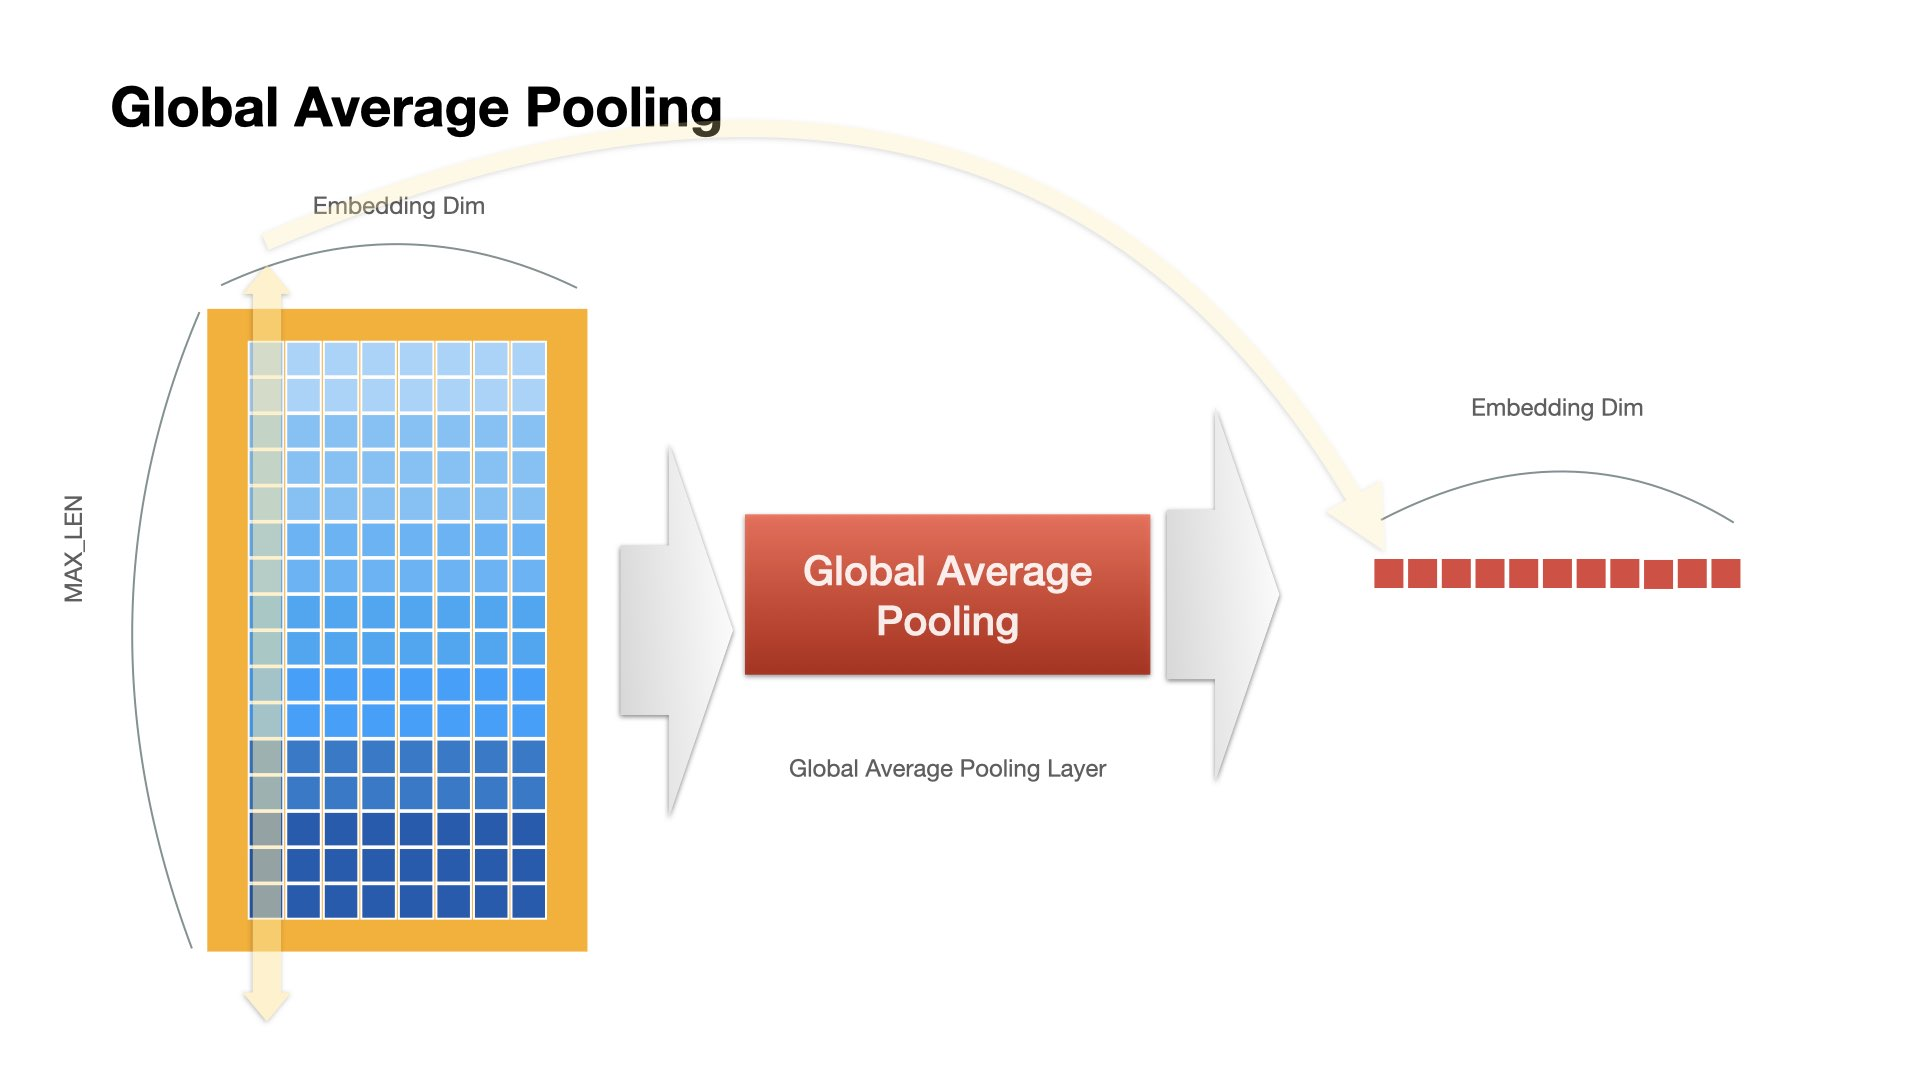

In [15]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential

# Input is max sequence length - 1, as we've removed the last word for the label
input_len = max_sequence_len - 1

model = Sequential()

# Add input embedding layer
model.add(Embedding(total_words, 10, input_length=input_len))
model.add(GlobalAveragePooling1D())
# Add Dense layer with 100 units
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.1))

# Add output layer
model.add(Dense(total_words, activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             117530    
                                                                 
 global_average_pooling1d (  (None, 10)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 11753)             129283    
                                                                 
Total params: 246923 (964.54 KB)
Trainable params: 246923 (964.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________

## Compiling the Model

As before, we compile our model with categorical crossentropy, as we're categorically predicting one word from our total vocabulary. In this case, we are not going to use accuracy as a metric, because text prediction is not measured as being more or less accurate in the same way as other tasks.

We are also going to select a particular optimizer that is well suited for sequential tasks, called the *Adam* optimizer. Details of optimizers are a bit out of scope for this course, but what's important to know is that different optimizers can be better for different deep learning tasks. You can read more about them, including the Adam optimizer [here](https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3).

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Training the Model

Similar to earlier sections, we fit our model in the same way. This time we'll train for 30 epochs, which will take a few minutes. You'll notice that we don't have a training or validation accuracy score in this case. This reflects our different problem of text prediction.

In [18]:
model.fit(predictors, labels, epochs=10, verbose=1) #You need almost 1200 produce text with sense

Epoch 1/10
1666/1666 [==============================] - 14s 8ms/step - loss: 8.0833
Epoch 2/10
1666/1666 [==============================] - 13s 8ms/step - loss: 7.5966
Epoch 3/10
1666/1666 [==============================] - 13s 8ms/step - loss: 7.5177
Epoch 4/10
1666/1666 [==============================] - 13s 8ms/step - loss: 7.4675
Epoch 5/10
1666/1666 [==============================] - 13s 8ms/step - loss: 7.4164
Epoch 6/10
1666/1666 [==============================] - 13s 8ms/step - loss: 7.3536
Epoch 7/10
1666/1666 [==============================] - 13s 8ms/step - loss: 7.2780
Epoch 8/10
1666/1666 [==============================] - 13s 8ms/step - loss: 7.1918
Epoch 9/10
1666/1666 [==============================] - 13s 8ms/step - loss: 7.0974
Epoch 10/10
1666/1666 [==============================] - 13s 8ms/step - loss: 7.0002


In [19]:
def predict_next_token(seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    prediction = np.argmax(model.predict(token_list),axis=1)
    return prediction

In [20]:
prediction = predict_next_token("today in new york")
prediction

1/1 [==============================] - 0s 310ms/step


array([38])

In [21]:
tokenizer.sequences_to_texts([prediction])

['york']

## Generate New Headlines

In [22]:
def generate_headline(seed_text, next_words=1):
    for _ in range(next_words):
        # Predict next token
        prediction = predict_next_token(seed_text)
        # Convert token to word
        next_word = tokenizer.sequences_to_texts([prediction])[0]
        # Add next word to the headline. This headline will be used in the next pass of the loop.
        seed_text += " " + next_word
    # Return headline as title-case
    return seed_text.title()

In [23]:
seed_texts = [
    'washington dc is',
    'today in new york',
    'the school district has',
    'crime has become']
for seed in seed_texts:
    print(generate_headline(seed, next_words=5))

1/1 [==============================] - 0s 19ms/step
Washington Dc Is To A The The Of
1/1 [==============================] - 0s 25ms/step
Today In New York York York For The The
1/1 [==============================] - 0s 20ms/step
The School District Has A A A Of The
1/1 [==============================] - 0s 21ms/step
Crime Has Become To A The The Of


## Lets follow the book architecture

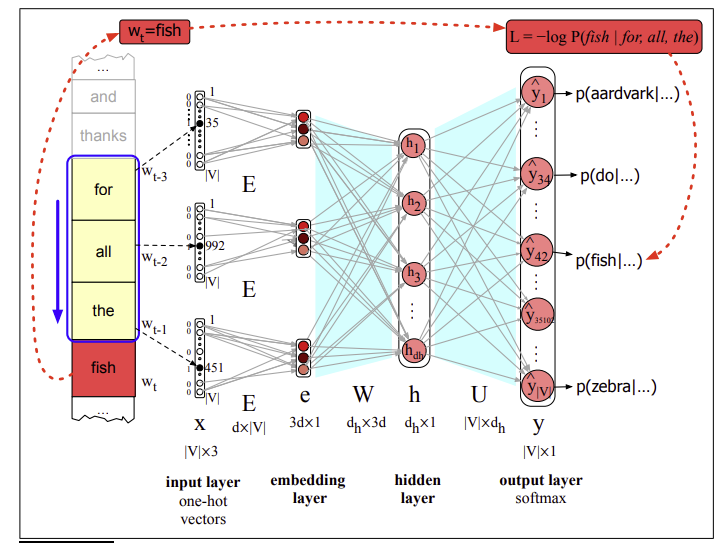

In [24]:
from tensorflow.keras.layers import Flatten
# Input is max sequence length - 1, as we've removed the last word for the label
input_len = max_sequence_len - 1

model = Sequential()

# Add input embedding layer
model.add(Embedding(total_words, 10, input_length=input_len))
model.add(Flatten())
# Add Dense layer with 100 units
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.1))

# Add output layer
model.add(Dense(total_words, activation='softmax'))

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 10)             117530    
                                                                 
 flatten (Flatten)           (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 11753)             129283    
                                                                 
Total params: 247123 (965.32 KB)
Trainable params: 247123 (965.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(predictors, labels, epochs=10, verbose=1) #You need almost 1200 produce text with sense

Epoch 1/10
1666/1666 [==============================] - 13s 7ms/step - loss: 8.0271
Epoch 2/10
1666/1666 [==============================] - 13s 8ms/step - loss: 7.4788
Epoch 3/10
1666/1666 [==============================] - 13s 8ms/step - loss: 7.3230
Epoch 4/10
1666/1666 [==============================] - 13s 8ms/step - loss: 7.1816
Epoch 5/10
1666/1666 [==============================] - 13s 8ms/step - loss: 7.0410
Epoch 6/10
1666/1666 [==============================] - 13s 8ms/step - loss: 6.8973
Epoch 7/10
1666/1666 [==============================] - 13s 8ms/step - loss: 6.7597
Epoch 8/10
1666/1666 [==============================] - 13s 8ms/step - loss: 6.6306
Epoch 9/10
1666/1666 [==============================] - 15s 9ms/step - loss: 6.5042
Epoch 10/10
1666/1666 [==============================] - 13s 8ms/step - loss: 6.3861


In [27]:
seed_texts = [
    'washington dc is',
    'today in new york',
    'the school district has',
    'crime has become']
for seed in seed_texts:
    print(generate_headline(seed, next_words=5))

1/1 [==============================] - 0s 24ms/step
Washington Dc Is A New York Today The
1/1 [==============================] - 0s 18ms/step
Today In New York Today The The New York
1/1 [==============================] - 0s 20ms/step
The School District Has The New York Today The
1/1 [==============================] - 0s 19ms/step
Crime Has Become A New York Today The
